In [ ]:
#Import necessary libraries.
import torch #Main library for working with tensors and neural network training on GPUs.
import os #Used for interacting with the operating system, like reading file paths.
import torch.nn as nn #Contains neural network layers and utilities.
import torchvision #Provides tools for image processing, pre-trained models, and datasets.
import torch.optim as optim #Includes optimization algorithms for training models.
import torch.nn.functional as F #Offers functions like activation functions and loss calculations.
from torch.utils.data import DataLoader,Dataset,random_split #Utilities for batch data processing and splitting datasets.
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.models import resnet50
from torchvision.datasets import ImageFolder,DatasetFolder
import matplotlib.pyplot as plt #Used for plotting graphs and visualizing data.
from sklearn.metrics import classification_report #Provides metrics for evaluating model performance, like classification reports.
import numpy as np #Essential for numerical operations on arrays.
from torchvision.transforms import Resize, RandomHorizontalFlip,RandomVerticalFlip,RandomGrayscale
from PIL import Image, ImageOps #Tools for image manipulation and processing.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = transforms.Compose([
    Resize((640,600)),
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.1),
    transforms.ToTensor()
])

In [ ]:
train_root = r"/kaggle/input/flowers-dataset/train"
test_root = r"/kaggle/input/flowers-dataset/test"

In [ ]:
# loads train data set, applies predefined image transformations  and then splits it into a larger training set and a smaller validation set.
train_dataset = ImageFolder(train_root , transform =transform)
train_set,val_set = random_split(train_dataset,[2471,275])


# Define a custom dataset class for the test data, applies optional transformations, and returns individual images for processing.
class CustomTestDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = os.listdir(root)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.root, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

#creates an instance of the CustomTestDataset class for the test dataset, applying transformations to convert images to tensors
#and resize them to specific dimensions.
test_dataset = CustomTestDataset(test_root, transform=transforms.Compose([transforms.ToTensor(),Resize((460,325))]))

# DataLoaders
#set up data loaders for the training, validation, and test datasets, configuring them to process images in batches of 64,
#with shuffling for training, and dropping the last incomplete batch in each set for consistent batch sizes.
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=64, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=64, drop_last=True)

In [ ]:
print(train_dataset.class_to_idx)

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


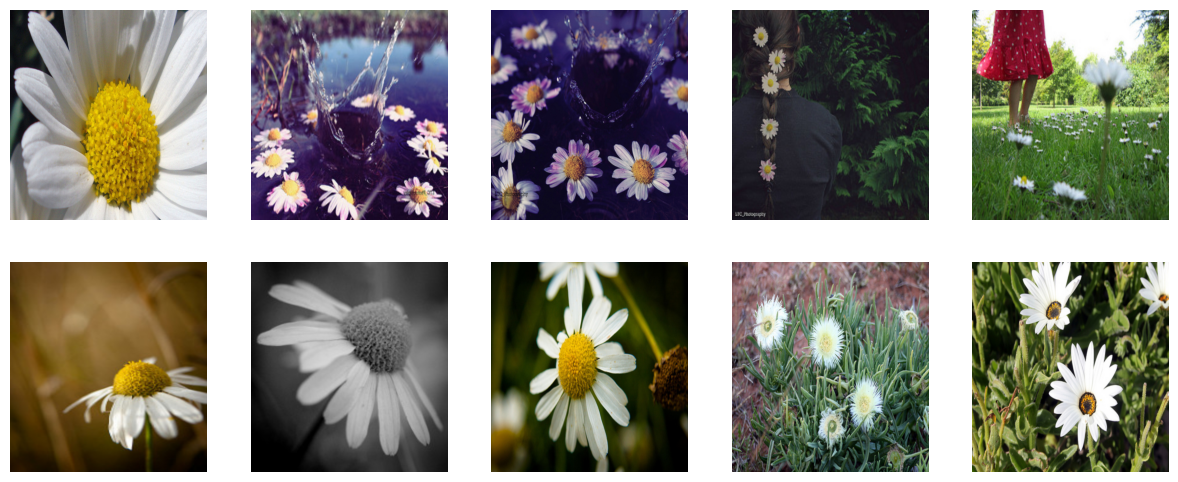

In [ ]:
# Visualize sample images from your dataset
num_samples = 10
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # Creating a grid of 2 rows and 5 columns for displaying 10 images

for i in range(num_samples):
    sample_image, _ = train_dataset[i]  # Get a sample image and its corresponding label (which we discard)
    transform = transforms.ToPILImage()
    sample_image = transform(sample_image)

    # Plot the image
    ax = axes[i // 5, i % 5]  # Calculate the subplot index
    ax.imshow(sample_image)
    ax.axis('off')

plt.show()

In [ ]:
# pretrained model

model = resnet50(pretrained = True)
for param in model.parameters():
    param.requires_grad = False
model.fc =nn.Linear(in_features = 2048 , out_features = 5 )

model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 155MB/s] 


In [ ]:
optimizer = optim.Adam(model.fc.parameters(),lr=0.0001)
criterion = nn.CrossEntropyLoss()

In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
epochs = 40

for epoch in range(epochs):
    total_train_loss = 0.0
    total_train_samples = 0
    total_train_correct = 0

    #Training: it updates the model weights based on the computed gradients from the loss between predicted and actual class labels.
    model.train()
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        scores = model(data)
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_samples += data.size(0)

        # Calculate training accuracy after each batch
        _, predictions = scores.max(1)
        total_train_correct += (predictions == targets).sum().item()

    # Calculate average training loss per epoch and Accuracy
    epoch_train_loss = (total_train_loss / total_train_samples)
    train_losses.append(epoch_train_loss)

    epoch_train_accuracy = (total_train_correct / total_train_samples)*100
    train_accuracies.append(epoch_train_accuracy)


    # Validation Loop: evaluates the model's performance without updating weights, providing insights into how well the model generalizes.
    model.eval()
    num_correct = 0
    num_samples = 0
    total_val_loss = 0.0
    val_predictions = []
    val_targets = []

    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            loss = criterion(scores, y)
            total_val_loss += loss.item()

            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum().item()
            num_samples += y.size(0)
            val_predictions.extend(predictions.cpu().numpy())
            val_targets.extend(y.cpu().numpy())

        val_acc = (float(num_correct) /float(num_samples)) * 100
        val_loss = total_val_loss / num_samples
        # Calculate average validation loss per epoch and Accuracy
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

    print(f'Epoch {epoch + 1}/{epochs} | Validation Accuracy: {val_acc:.2f} | Validation Loss: {val_loss:.4f}')

#Performance metrics such as loss and accuracy are tracked for both training and validation phases,
print(f'Validation Accuracy: {val_acc:.2f} | Validation Loss: {val_loss:.4f}')

# Classification report  to assess model precision, recall, and F1-score per class.
val_report = classification_report(val_targets, val_predictions, target_names=train_dataset.classes)
print("Classification Report - Validation Data:")
print(val_report)

Epoch 1/40 | Validation Accuracy: 62.11 | Validation Loss: 0.0206
Epoch 2/40 | Validation Accuracy: 69.53 | Validation Loss: 0.0187
Epoch 3/40 | Validation Accuracy: 76.17 | Validation Loss: 0.0169
Epoch 4/40 | Validation Accuracy: 77.34 | Validation Loss: 0.0156
Epoch 5/40 | Validation Accuracy: 79.69 | Validation Loss: 0.0145
Epoch 6/40 | Validation Accuracy: 79.30 | Validation Loss: 0.0135
Epoch 7/40 | Validation Accuracy: 79.69 | Validation Loss: 0.0128
Epoch 8/40 | Validation Accuracy: 82.03 | Validation Loss: 0.0121
Epoch 9/40 | Validation Accuracy: 84.77 | Validation Loss: 0.0116
Epoch 10/40 | Validation Accuracy: 82.81 | Validation Loss: 0.0111
Epoch 11/40 | Validation Accuracy: 85.94 | Validation Loss: 0.0106
Epoch 12/40 | Validation Accuracy: 84.77 | Validation Loss: 0.0103
Epoch 13/40 | Validation Accuracy: 84.38 | Validation Loss: 0.0100
Epoch 14/40 | Validation Accuracy: 83.59 | Validation Loss: 0.0099
Epoch 15/40 | Validation Accuracy: 85.55 | Validation Loss: 0.0095
Epoc

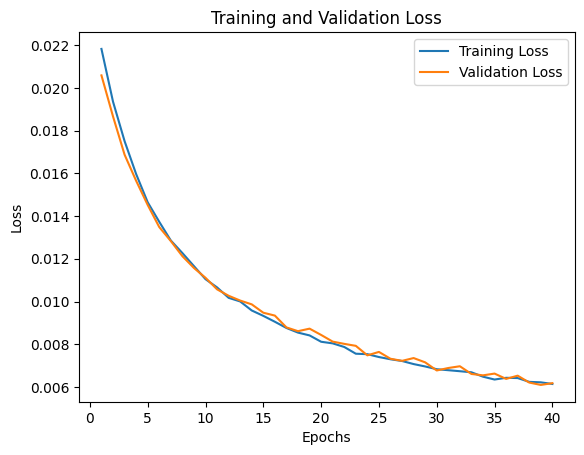

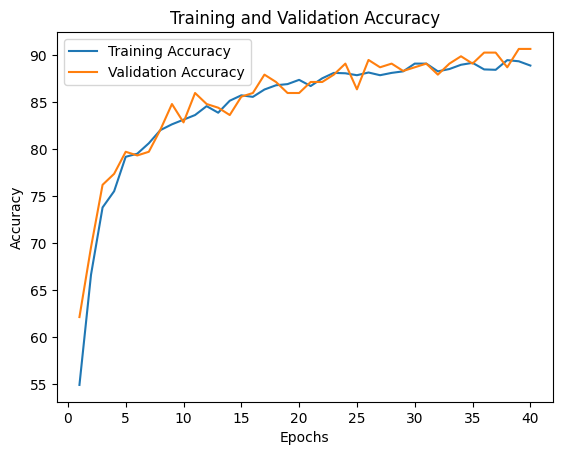

In [ ]:
epochs = range(1, len(train_losses) + 1)

# Loss plot:
plt.figure()
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Accuracy plot:
plt.figure()
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:
model.eval()

predictions = []
with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        # Forward pass
        outputs = model(images)
        # Get predicted class
        _, predicted = torch.max(outputs, 1)
        # Append predictions
        predictions.extend(predicted.cpu().numpy())

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Print the predicted labels for each test image
print(predictions)



[2 3 2 4 3 1 1 2 4 3 2 3 1 1 1 0 4 1 0 3 2 1 2 4 3 2 1 3 3 0 4 1 1 0 3 3 0
 1 1 4 3 4 4 0 2 0 4 3 2 2 3 1 2 2 1 1 0 0 4 2 2 3 4 2 0 3 2 1 1 2 4 4 2 4
 4 4 0 3 3 0 3 2 1 3 4 3 4 3 3 1 4 3 3 3 4 2 0 4 4 2 1 3 0 4 4 3 4 1 4 1 0
 4 1 0 2 0 4 0 2 4 0 4 3 1 1 1 1 1 0 0 4 3 3 0 0 1 3 2 0 4 1 4 1 3 3 1 1 1
 1 3 0 1 4 0 4 3 0 2 4 3 1 3 0 1 3 2 4 1 2 3 4 2 1 1 4 3 2 1 2 1 4 3 4 1 1
 3 1 2 3 4 4 2 0 4 1 3 3 4 4 3 1 1 0 4 1 0 3 0 2 3 2 0 1 1 3 2 4 2 1 1 1 0
 4 3 3 1 4 1 0 2 3 0 1 4 0 4 1 2 0 4 3 3 1 3 1 2 3 2 4 4 4 4 2 3 2 2 1 1 3
 2 1 4 1 2 4 2 4 1 0 4 0 3 2 3 0 4 1 4 1 0 3 3 4 4 3 3 0 3 0 2 0 1 4 3 0 0
 3 2 2 4 2 0 4 1 1 4 1 4 2 1 0 0 4 0 4 4 3 4 0 1 1 1 0 4 0 2 3 4 4 2 4 4 3
 1 1 3 1 2 3 4 4 4 3 3 3 4 4 0 0 4 3 3 4 1 3 3 2 0 3 4 1 4 2 3 1 3 3 1 2 4
 4 0 3 0 4 1 3 4 2 1 0 2 3 3 4 1 4 4 3 0 0 0 0 1 4 0 4 3 4 4 1 0 1 4 3 1 0
 1 2 2 4 1 4 3 4 4 0 2 4 3 1 1 2 3 1 2 4 1 4 2 3 1 1 2 0 1 2 0 0 3 4 4 4 4
 1 1 2 1 2 1 0 4 3 0 1 1 2 3 0 1 4 3 3 4 1 3 3 4 4 1 3 4 4 0 2 2 3 1 4 1 0
 2 2 1 3 3 4 3 4 1 1 4 1 